# Intercomparison

**Author:** Ivan Zvonkov

**Last updated:** September 11, 2023

**Description:** Runs intercomparison for Senegal 2022

## 1. Setup

In [ ]:
# !earthengine authenticate

In [1]:
import ee
import geemap
import sys
import pandas as pd
import geopandas as gpd

ee.Initialize()

sys.path.append("../..")

In [2]:
from src.compare_covermaps import TARGETS, filter_by_bounds, generate_report, LAT, LON, CLASS_COL, COUNTRY_COL

## 2. Read in evaluation set

In [7]:
country = "Senegal"
country_code = "SEN"
dataset_path = "../../data/datasets/Senegal_CEO_2022.csv"

In [8]:
df = pd.read_csv(dataset_path)[["lat", "lon", "class_probability", "subset"]]
df = df[(df["class_probability"] != 0.5)].copy()
df = df[(df["subset"] == "validation") | (df["subset"] == "testing")].copy()
df[CLASS_COL] = (df["class_probability"] > 0.5).astype(int)
df[COUNTRY_COL] = country

gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.lon, df.lat), crs="epsg:4326")
gdf = filter_by_bounds(country_code=country_code, gdf=gdf)
gdf.head()

,lat,lon,class_probability,subset,binary,country,geometry
0,15.033306,-16.937735,0.0,testing,0,Senegal,POINT (-16.93773 15.03331)
2,16.192133,-14.772795,0.0,validation,0,Senegal,POINT (-14.77279 16.19213)
3,15.015340,-13.173794,0.0,validation,0,Senegal,POINT (-13.17379 15.01534)
4,14.799744,-15.329750,0.0,testing,0,Senegal,POINT (-15.32975 14.79974)
5,14.260755,-14.656014,0.0,testing,0,Senegal,POINT (-14.65601 14.26076)


In [9]:
len(gdf)

1051

## 3. Run intercomparison

In [10]:
TARGETS = {k:v for k,v in TARGETS.items()}

In [16]:
for cropmap in TARGETS.values():
    if cropmap.countries is not None and country not in cropmap.countries:
        continue
    print(f"[{country}] sampling " + cropmap.title + "...")
    map_sampled = cropmap.extract_test(gdf).copy()
    gdf = pd.merge(gdf, map_sampled, on=[LAT, LON], how="left")
    gdf.drop_duplicates(inplace=True)  # TODO find why points get duplicated

In [18]:
cropmap.countries

['Tanzania',
 'Namibia',
 'Uganda',
 'Zambia',
 'Hawaii',
 'BlueNile2020',
 'BlueNile2019',
 'AlGadaref2019',
 'BureJimma2019',
 'BureJimma2020',
 'Tigray2021',
 'Tigray2020']

In [12]:
gdf_val = gdf[gdf["subset"] == "validation"].copy()
gdf_test = gdf[gdf["subset"] == "testing"].copy()

comparisons = []
for cropmap in TARGETS.keys():
    if cropmap not in gdf.columns:
        continue
    temp = gdf_val[[CLASS_COL, cropmap]].dropna()
    comparison = generate_report(cropmap, country, temp[CLASS_COL], temp[cropmap])
    comparisons.append(comparison)

results = pd.concat(comparisons).set_index(["dataset"])

# Add ensemble
ensemble_maps = list(results["crop_f1"].nlargest(3).index) # Should be odd number
print(f"Ensemble maps: {ensemble_maps}")
ensemble = gdf_val[ensemble_maps].mode(axis='columns')
comparison = generate_report("ensemble-subset", country, gdf_val[CLASS_COL], ensemble)
comparisons.append(comparison)

results = pd.concat(comparisons).set_index(["dataset"])
results

ValueError: No objects to concatenate

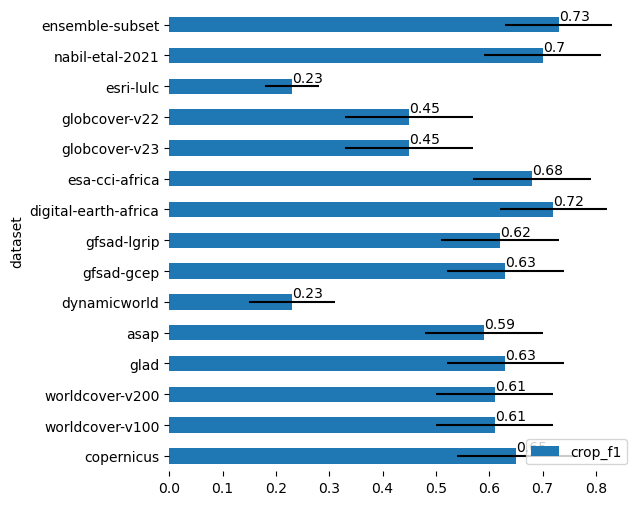

In [81]:
ax = results.plot(
    y="crop_f1", #"accuracy", "crop_precision_ua", "crop_recall_pa"], 
    xerr="std_crop_f1",
    kind="barh", 
    figsize=(6,6)
);
for p in ax.patches:
    ax.annotate(str(p.get_width()), (p.get_width(), p.get_y() + 0.4))

for border in ["top", "right", "bottom", "left"]:
    ax.spines[border].set_visible(False)

## 4. Visualize best available map

In [82]:
best_dataset = results["crop_f1"].idxmax()

In [83]:
ensemble = gdf_test[ensemble_maps].mode(axis='columns')
comparison = generate_report("ensemble-subset", country, gdf_test[CLASS_COL], ensemble)
comparison

,dataset,country,crop_f1,std_crop_f1,accuracy,std_acc,crop_recall_pa,std_crop_pa,noncrop_recall_pa,std_noncrop_pa,crop_precision_ua,std_crop_ua,noncrop_precision_ua,std_noncrop_ua,crop_support,noncrop_support,tn,fp,fn,tp
0,ensemble-subset,Togo,0.64,0.12,0.75,0.02,0.6,0.03,0.84,0.02,0.68,0.05,0.78,0.03,118,201,168,33,47,71


In [89]:
# Run this cell to view and export map
print("To view and export map copy and paste the text below the dashed line into GEE\n" + "-"*100)
if best_dataset in TARGETS:
    print(TARGETS[best_dataset].ee_script(country))
else:
    image_var_names = [TARGETS[d].title_safe for d in ensemble_maps]
    for i, dataset in enumerate(ensemble_maps):
        print(TARGETS[dataset].ee_script(country, include_prefix=(i == 0), include_export=False))
        print("\n")
    print(f"var ensemble = ee.ImageCollection.fromImages([{', '.join(image_var_names)}]).mode()")
    print(f"Map.addLayer(ensemble, classVis, 'Cropland from ensemble');")
    print(f"""
Export.image.toCloudStorage({{
    image: ensemble,
    description: "{country}_ensemble_{'_'.join(image_var_names)}",
    bucket: 'crop-mask-preds-merged',
    fileNamePrefix: "{country}_ensemble_{'_'.join(image_var_names)}",
    region: aoi,
    scale: 10,
    crs: "EPSG:4326",
    maxPixels: 1e10,
    skipEmptyTiles: true
}});""")

Copy and paste the text below the dashed line into GEE
----------------------------------------------------------------------------------------------------

var palettes = require('users/gena/packages:palettes');
var classVis = {palette: palettes.cmocean.Speed[7].slice(0,-2)}
var aoi = ee.FeatureCollection("FAO/GAUL/2015/level0").filter(ee.Filter.eq('ADM0_NAME', 'Togo'));
Map.centerObject(aoi, 7);

var digital_earth_africa = ee.ImageCollection("projects/sat-io/open-datasets/DEAF/CROPLAND-EXTENT/filtered").filterBounds(aoi).mosaic().clip(aoi);
digital_earth_africa = digital_earth_africa.eq(1)
Map.addLayer(digital_earth_africa, classVis, 'Cropland from digital-earth-africa');


var nabil_etal_2021 = ee.ImageCollection.fromImages(
            [ee.Image("projects/sat-io/open-datasets/landcover/AF_Cropland_mask_30m_2016_v3")]
        ).filterBounds(aoi).mosaic().clip(aoi);
nabil_etal_2021 = nabil_etal_2021.eq(2)
Map.addLayer(nabil_etal_2021, classVis, 'Cropland from nabil-etal-2021');


var